# Dogs vs Cats

- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
- http://aidiary.hatenablog.com/entry/20170108/1483876657
- http://aidiary.hatenablog.com/entry/20170603/1496493646

In [20]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

## データ整形

- https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
- train.zipとtest.zipをカレントディレクトリにダウンロードしておく

In [2]:
!ls data/

20170104210653.jpg        dogscats                  picasso.jpg
20170104210658.jpg        hymenoptera_data          processed
20170104210705.jpg        hymenoptera_data.zip      raw
cifar-10-batches-py       hymenoptera_data.zip.1    test.zip
cifar-10-python.tar.gz    imagenet_class_index.json train.txt
dancing.jpg               mnist                     train.zip


In [8]:
import os
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data', 'dogscats')
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

In [20]:
!mkdir $data_dir

In [ ]:
!unzip train.zip -d $data_dir

In [ ]:
!unzip test.zip -d $data_dir

In [33]:
!ls -1 $train_dir | wc -l

   25000


In [34]:
!ls -1 $test_dir | wc -l

   12500


訓練データからランダムに選んだ2000画像をvalidationデータとする

In [26]:
!mkdir $valid_dir

In [ ]:
%cd $train_dir

import os
from glob import glob
import numpy as np
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000):
    os.rename(shuf[i], os.path.join(valid_dir, shuf[i]))

In [36]:
!ls -1 $valid_dir | wc -l

    2000


- PyTorchで読み込みやすいようにクラスごとにサブディレクトリを作成する
- Kaggleのテストデータは正解ラベルがついていないため unknown というサブディレクトリにいれる

In [ ]:
# train
%cd $train_dir
%mkdir cats dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
# valid
%cd $valid_dir
%mkdir cats dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
# test
%cd $test_dir
%mkdir unknown
%mv *.jpg unknown

## 最終的なディレクトリ構造

## VGG16 の出力層のみ置き換える

- 分類層を除いたネットワークのパラメータを固定する
- 分類層のパラメータのみ学習対象

In [9]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()  # eval mode!

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

- 層の置き換え
- 下のように (classifier) の (6) だけを置き換えることはできないみたい 

```
# 最後のfc層のみ2クラス分類できるように置き換える
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 2)  # <= この代入はできない！
```

- classifierをまるごと置き換える必要がある

In [10]:
# 全層のパラメータを固定
for param in vgg16.parameters():
    param.requires_grad = False

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2)    
)

use_gpu = torch.cuda.is_available()
if use_gpu:
    vgg16 = vgg16.cuda()

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

- VGG用のデータ変換を定義
- 訓練もテストも (224, 224) にサイズ変更のみ
- 正方形の画像でないので `Resize(224)` は動作しない
- 最初はデータ拡張は使わないで試す

In [11]:
train_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## データをロード

In [12]:
train_dataset = datasets.ImageFolder(train_dir, train_preprocess)
valid_dataset = datasets.ImageFolder(valid_dir, test_preprocess)
test_dataset = datasets.ImageFolder(test_dir, test_preprocess)

In [13]:
# DataSetのlenはサンプル数
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

23000
2000
12500


- クラスはアルファベット順？

In [14]:
classes = train_dataset.classes
print(train_dataset.classes)
print(valid_dataset.classes)
print(test_dataset.classes)

['cats', 'dogs']
['cats', 'dogs']
['unknown']


In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128,
                                          shuffle=False)

In [16]:
# DataLoaderのlenはミニバッチ数
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

180
16
98


torch.Size([128, 3, 224, 224]) torch.Size([128])


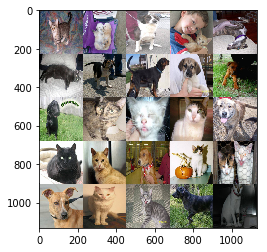

In [21]:
def imshow(images, title=None):
    images = images.numpy().transpose((1, 2, 0))  # (h, w, c)
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    if title is not None:
        plt.title(title)

images, classes = next(iter(train_loader))
print(images.size(), classes.size())
images = torchvision.utils.make_grid(images[:25], nrow=5)
imshow(images)

## モデル訓練

- optimizerには更新対象のパラメータのみ渡す必要がある！
- `requires_grad = False` している `vgg16.parameters()` を指定するとエラーになる

In [22]:
if use_gpu:
    vgg16 = vgg16.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

In [23]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        if use_gpu:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        running_loss += loss.data[0]
        
        loss.backward()
        optimizer.step()
    
    train_loss = running_loss / len(train_loader)
    
    return train_loss


def valid(model, criterion, valid_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(valid_loader):
        if use_gpu:
            images = Variable(images.cuda(), volatile=True)
            labels = Variable(labels.cuda(), volatile=True)
        else:
            images = Variable(images, volatile=True)
            labels = Variable(labels, volatile=True)

        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.data[0]

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        total += labels.size(0)

    val_loss = running_loss / len(valid_loader)
    val_acc = correct / total
    
    return val_loss, val_acc

In [18]:
%mkdir logs

In [ ]:
num_epochs = 5
log_dir = './logs'

best_acc = 0
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(vgg16, criterion, optimizer, train_loader)
    val_loss, val_acc = valid(vgg16, criterion, valid_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    if val_acc > best_acc:
        print('val_acc improved from %.5f to %.5f!' % (best_acc, val_acc))
        best_acc = val_acc
        model_file = 'epoch%03d-%.3f-%.3f.pth' % (epoch, val_loss, val_acc)
        torch.save(vgg16.state_dict(), os.path.join(log_dir, model_file))

    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

認識率：99.3%

```
epoch 0, loss: 0.1068 val_loss: 0.0346 val_acc: 0.9905
val_acc improved from 0.00000 to 0.99050!
epoch 1, loss: 0.0351 val_loss: 0.0316 val_acc: 0.9925
val_acc improved from 0.99050 to 0.99250!
epoch 2, loss: 0.0267 val_loss: 0.0315 val_acc: 0.9930
val_acc improved from 0.99250 to 0.99300!
epoch 3, loss: 0.0224 val_loss: 0.0317 val_acc: 0.9930
epoch 4, loss: 0.0175 val_loss: 0.0311 val_acc: 0.9920
```